In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

TensorFlow Version: 2.18.0
Keras Version: 3.8.0


# Objective

This project aims to forecast a particular IT department expenses for software licenses used by team members. By leveraging deep learning models, it forecasts future costs, enabling better budget planning and expense management.

# Data Loading

In [2]:
data = pd.read_csv('expenses.csv', header = None)
data.columns = ['Month','Expenses']
data['Month'] = pd.to_datetime(data['Month'], format='%d-%m-%Y').dt.to_period('M').dt.to_timestamp()
data = data.set_index('Month')
data = data.asfreq('MS')
data.head(12)

,Expenses
Month,
2012-01-01,637.8
2012-02-01,667.9
2012-03-01,639.4
2012-04-01,596.1
2012-05-01,604.9
2012-06-01,567.5
2012-07-01,566.4
2012-08-01,586.3
2012-09-01,622.6


In [ ]:
data.tail()

,Expenses
Month,
2024-03-01,1225.7
2024-04-01,1276.7
2024-05-01,1336.6
2024-06-01,1276.3
2024-07-01,1313.2


In [ ]:
data.shape

(151, 1)

# Data Analysis

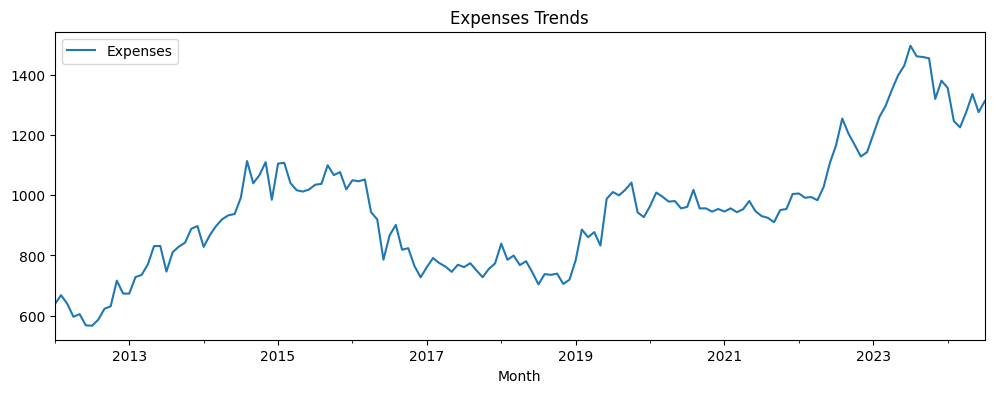

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Expenses Trends')
plt.show(block=False)

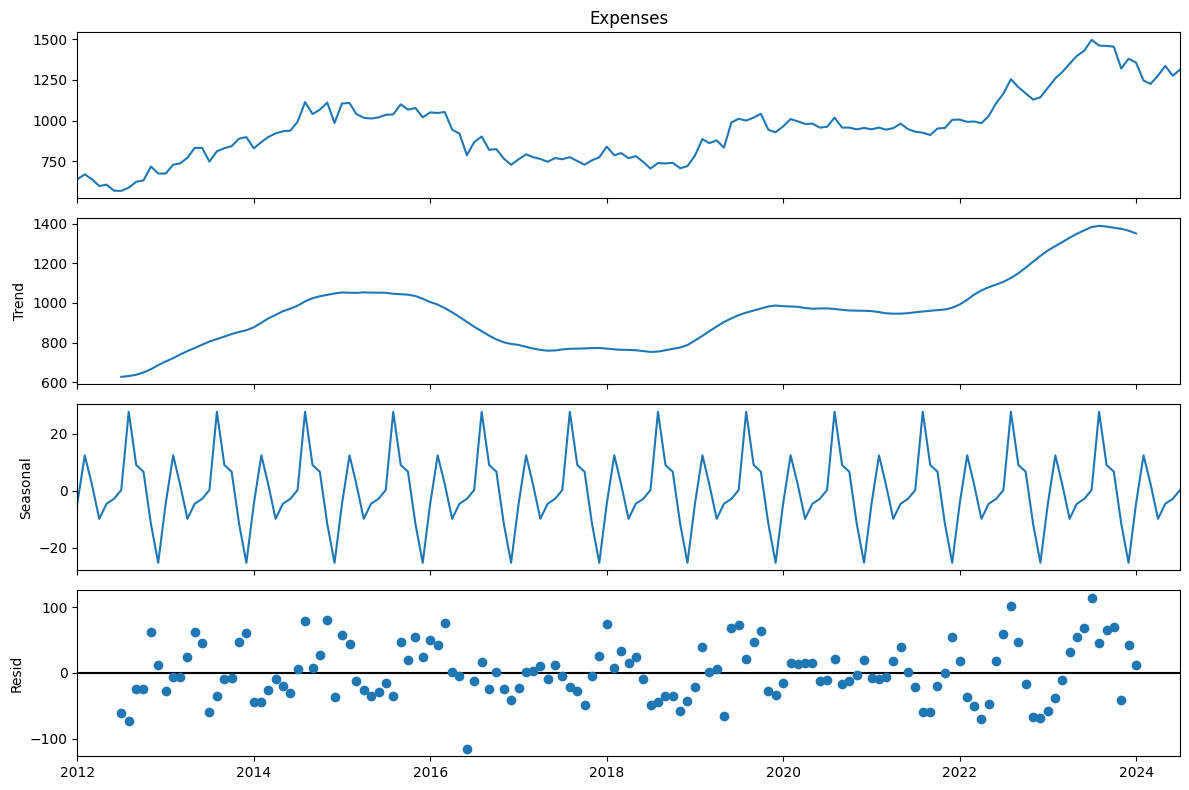

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Expenses, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

The trend is not steadily rising. There are fluctuations noted. There is also seasonality in data, which repeats over the year. Even after capturing seasonality, the residuals still show some amount of seasonality which cannot be explained. Let us check the multiplicative seasonality.

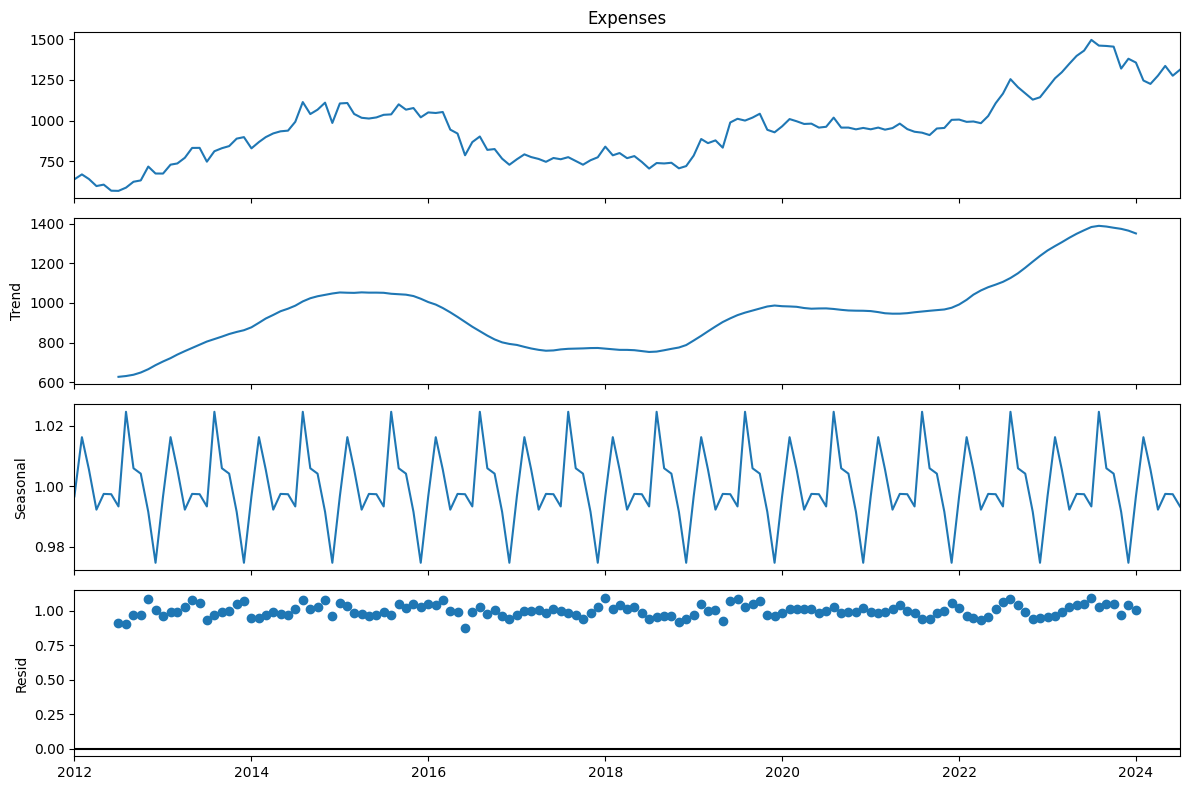

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data.Expenses, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

Here also rising trend and seasonality shown. But here the residuals look random and dont follow any particular pattern.

# Splitting Data

In [ ]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

# Stationarity Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train['Expenses'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.852109
Critical Values @ 0.05: -2.89
p-value: 0.051207


Series border non stationarity slightly.

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train['Expenses'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.329372
Critical Values @ 0.05: 0.46
p-value: 0.100000


Series is stationary

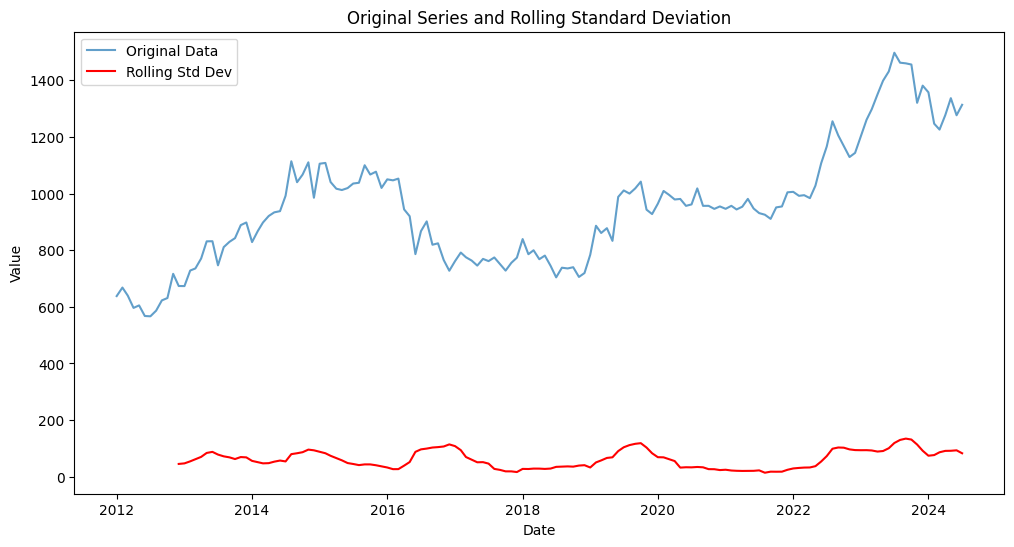

In [ ]:
# Rolling window standard deviation
window_size = 12  # Adjust as needed
rolling_std = data['Expenses'].rolling(window=window_size).std()

# Plot the original series and its rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Expenses'], label='Original Data', alpha=0.7)
plt.plot(data.index, rolling_std, label='Rolling Std Dev', color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series and Rolling Standard Deviation')
plt.legend()
plt.show()

The rolling standard deviation (red line) is relatively stable over time. It fluctuates slightly but does not show large, increasing variations. This suggests that variance is not severely heteroscedastic.

# ACF and PACF

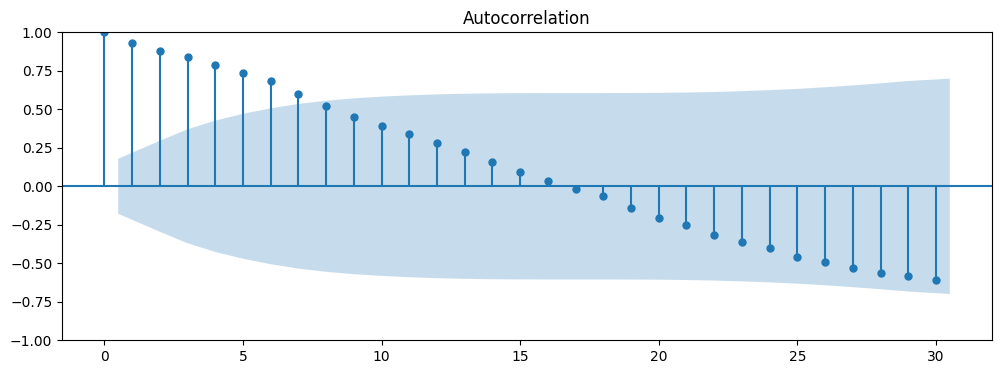

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train, ax=plt.gca(), lags = 30)
plt.show()

The ACF shows a gradual decline. There might be need for first differencing.
Significant positive autocorrelations at multiple lags, reducing over time.
This suggests a strong moving average (MA) component in the data.

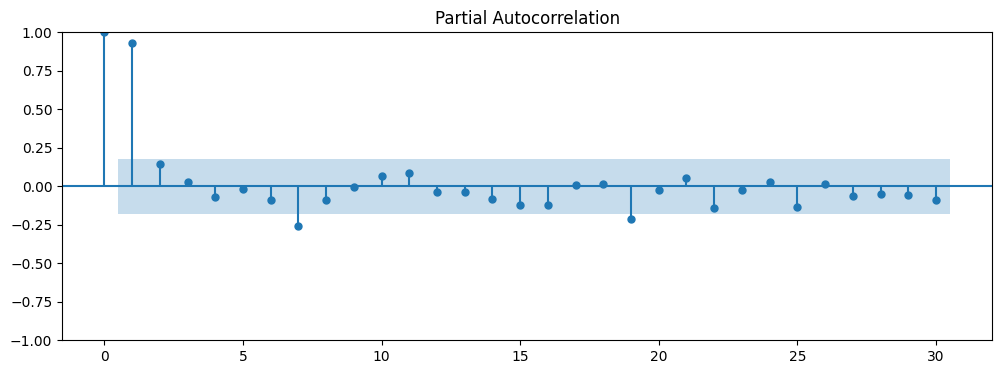

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 30)
plt.show()

The PACF shows a sharp cut-off after lag 2.
The first few lags are significant, but then the values drop within the confidence interval.
This suggests a possible autoregressive (AR) process of order p = 2.

# Model 1

In [ ]:
model = sm.tsa.ARIMA(train['Expenses'], order=(2, 1, 0))
model_fit = model.fit()

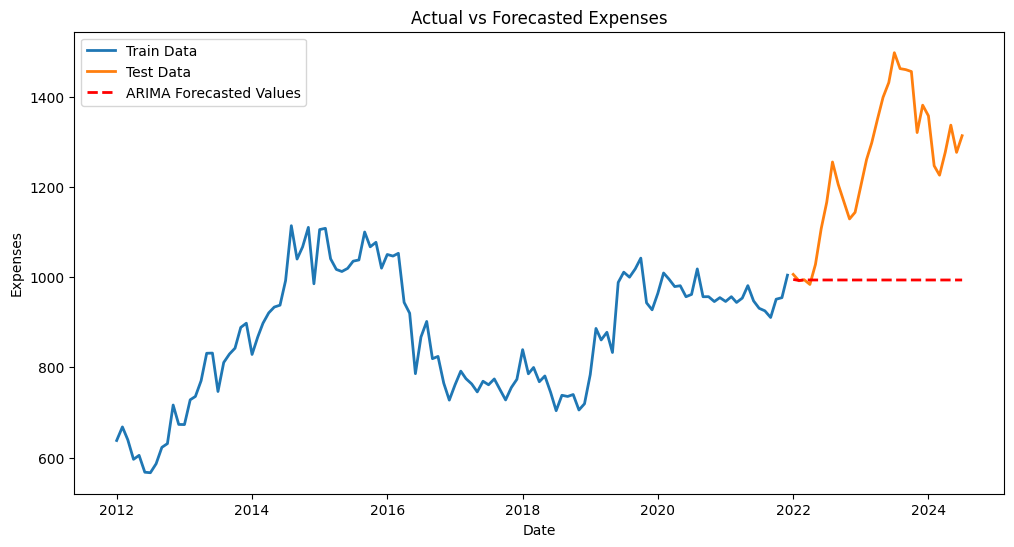

In [ ]:
# Predict for test data
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

# Plot results
plt.figure(figsize=(12, 6))

# Plot train data
plt.plot(train.index, train['Expenses'], label='Train Data', linewidth=2)

# Plot test data (actual values)
plt.plot(test.index, test['Expenses'], label='Test Data', linewidth=2)

# Plot forecasted values
plt.plot(forecast.index, forecast, label='ARIMA Forecasted Values', linewidth=2, linestyle='dashed', color='red')

plt.xlabel('Date')
plt.ylabel('Expenses')
plt.title('Actual vs Forecasted Expenses')
plt.legend()
plt.show()

# Model 2

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

## Minmaxscale

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Expenses']])
# Convert back to DataFrame for easier indexing
train_scaled = pd.DataFrame(train_scaled, index=train.index, columns=['Expenses'])

In [ ]:
train_scaled.shape

(120, 1)

In [ ]:
train_scaled.tail()

,Expenses
Month,
2021-08-01,0.655280
2021-09-01,0.628425
2021-10-01,0.702411
2021-11-01,0.708623
2021-12-01,0.799781


In [ ]:
test_scaled = scaler.transform(test[['Expenses']])
# Convert back to DataFrame for easier indexing
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=['Expenses'])

In [ ]:
test_scaled.head()

,Expenses
Month,
2022-01-01,0.802886
2022-02-01,0.777128
2022-03-01,0.781330
2022-04-01,0.762148
2022-05-01,0.843076


## Sequence Creation

In [ ]:
# Define function to create sequences for LSTM
def create_sequences(data, seq_length=6):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length].values)
    return np.array(X), np.array(y)

In [ ]:
# merging to ensure continuity
fulldata=pd.concat([train_scaled,test_scaled])
fulldata.shape

(151, 1)

In [ ]:
x_full, y_full = create_sequences(fulldata)

In [ ]:
split_index = len(train_scaled) - 6

In [ ]:
# Split data
x_train, y_train = x_full[:split_index], y_full[:split_index]
x_test, y_test = x_full[split_index:], y_full[split_index:]

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((114, 6, 1), (31, 6, 1), (114, 1), (31, 1))

In [ ]:
x_train[-1]

array([[0.69546949],
       [0.66569236],
       [0.6552795 ],
       [0.62842528],
       [0.7024114 ],
       [0.70862258]])

In [ ]:
y_train[-1]

array([0.79978078])

In [ ]:
x_test[0]

array([[0.66569236],
       [0.6552795 ],
       [0.62842528],
       [0.7024114 ],
       [0.70862258],
       [0.79978078]])

## LSTM 1

In [ ]:
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(6, 1)),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mse',metrics=['root_mean_squared_error'])

In [ ]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.3914 - root_mean_squared_error: 0.6253 - val_loss: 1.3664 - val_root_mean_squared_error: 1.1689
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2890 - root_mean_squared_error: 0.5376 - val_loss: 1.1148 - val_root_mean_squared_error: 1.0558
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2196 - root_mean_squared_error: 0.4685 - val_loss: 0.8449 - val_root_mean_squared_error: 0.9192
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1483 - root_mean_squared_error: 0.3849 - val_loss: 0.5414 - val_root_mean_squared_error: 0.7358
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0721 - root_mean_squared_error: 0.2676 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5031
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0250 - root_mean_squared_error: 0.1577 - val_loss: 0.0698 - val_root_mean_squared_error: 0.2641
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0288 - roo

Overfit noted. root_mean_square for validation data is twice that for train data.

## LSTM 2

In [ ]:
model2 = Sequential([
    LSTM(32, return_sequences=True, input_shape=(6, 1)),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

In [ ]:
# Compile model
model2.compile(optimizer='adam', loss='mse',metrics=['root_mean_squared_error'])

In [ ]:
history = model2.fit(x_train, y_train, epochs=50, batch_size=8, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.2236 - root_mean_squared_error: 0.4705 - val_loss: 0.1869 - val_root_mean_squared_error: 0.4323
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2522
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - root_mean_squared_error: 0.1421 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0166 - root_mean_squared_error: 0.1286 - val_loss: 0.0676 - val_root_mean_squared_error: 0.2601
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - root_mean_squared_error: 0.1176 - val_loss: 0.0876 - val_root_mean_squared_error: 0.2960
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - root_mean_squared_error: 0.1220 - val_loss: 0.0602 - val_root_mean_squared_error: 0.2453
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss:

Overfit reduced.

## LSTM 3

In [ ]:
model3 = Sequential([
    LSTM(32, return_sequences=True, recurrent_dropout=0.1, input_shape=(6, 1)),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

In [ ]:
# Compile model
model3.compile(optimizer='adam', loss='mse',metrics=['root_mean_squared_error'])

In [ ]:
history = model3.fit(x_train, y_train, epochs=50, batch_size=8, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.3505 - root_mean_squared_error: 0.5910 - val_loss: 0.7701 - val_root_mean_squared_error: 0.8775
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0768 - root_mean_squared_error: 0.2752 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1807
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0383 - root_mean_squared_error: 0.1946 - val_loss: 0.1831 - val_root_mean_squared_error: 0.4280
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0158 - root_mean_squared_error: 0.1250 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3134
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0175 - root_mean_squared_error: 0.1316 - val_loss: 0.1097 - val_root_mean_squared_error: 0.3312
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0171 - root_mean_squared_error: 0.1305 - val_loss: 0.0747 - val_root_mean_squared_error: 0.2732
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss:

Overfit reduced. root_mean_squared_error difference between train and validation data is 0.0752.

train root_mean_squared_error: 0.1130

validation root_mean_squared_error: 0.1882

In [ ]:
# Make predictions
train_pred = model3.predict(x_train)
test_pred = model3.predict(x_test)

# Inverse transform predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


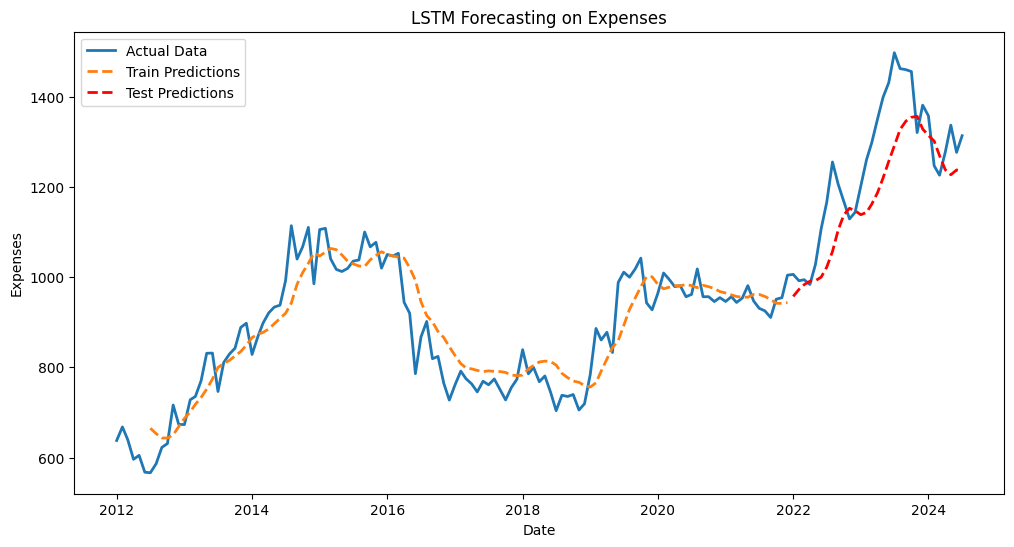

In [ ]:
train_pred = train_pred.flatten()
test_pred = test_pred.flatten()
y_train_inv = y_train_inv.flatten()
y_test_inv = y_test_inv.flatten()

# Adjust index alignment
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Expenses'], label='Actual Data', linewidth=2)

# Plot train predictions
plt.plot(train.index[6:], train_pred, label='Train Predictions', linewidth=2, linestyle='dashed')

# Plot test predictions
plt.plot(test.index, test_pred, label='Test Predictions', linewidth=2, linestyle='dashed', color='red')

plt.xlabel('Date')
plt.ylabel('Expenses')
plt.title('LSTM Forecasting on Expenses')
plt.legend()
plt.show()

# Test

Using rolling approach of forecasting to forecast expenses till July 2025.

In [ ]:
import numpy as np

# Define the number of months to forecast
forecast_horizon = 12

# Get the last sequence from training data as the starting point
last_sequence = x_test[-1]  # Shape: (6,1), last known sequence

rolling_forecast = []

# Generate predictions iteratively
for _ in range(forecast_horizon):
    next_pred = model3.predict(last_sequence.reshape(1, 6, 1))  # Predict next step
    rolling_forecast.append(next_pred[0, 0])  # Store prediction

    # Update the sequence by appending the new prediction and removing the oldest value
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(6, 1)

# Convert predictions back to original scale
rolling_forecast = np.array(rolling_forecast).reshape(-1, 1)
rolling_forecast_inv = scaler.inverse_transform(rolling_forecast)

# Create future date index
future_dates = pd.date_range(start=test.index[-1], periods=forecast_horizon+1, freq='M')[1:]




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


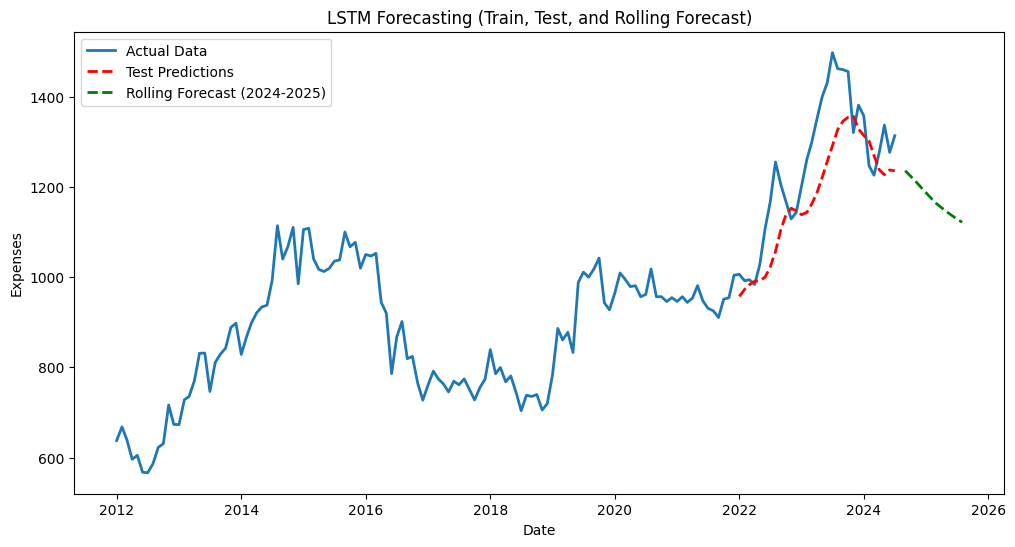

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Expenses'], label='Actual Data', linewidth=2)
plt.plot(test.index, test_pred, label='Test Predictions', linewidth=2, linestyle='dashed', color='red')
plt.plot(future_dates, rolling_forecast_inv, label=f'Rolling Forecast ({future_dates.year[0]}-{future_dates.year[-1]})',
         linewidth=2, linestyle='dashed', color='green')

plt.xlabel('Date')
plt.ylabel('Expenses')
plt.title('LSTM Forecasting (Train, Test, and Rolling Forecast)')
plt.legend()
plt.show()

# Conclusion

The LSTM model with dropout was used to predict future expenses. The train RMSE was 0.113, while the validation RMSE was 0.188. A 1-year forecast for unseen data was generated using a rolling approach.